In [365]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [366]:
data = smapi.datasets.sunspots.load_pandas().data


In [367]:
df = data.copy()
df.YEAR = pd.to_datetime(df.YEAR, format='%Y')
df = df.set_index('YEAR')
df


,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2


In [368]:
#df = df['SUNACTIVITY'].resample('MS').mean()
df = df.fillna(df.bfill())
df.info

<bound method DataFrame.info of             SUNACTIVITY
YEAR                   
1700-01-01          5.0
1701-01-01         11.0
1702-01-01         16.0
1703-01-01         23.0
1704-01-01         36.0
...                 ...
2004-01-01         40.4
2005-01-01         29.8
2006-01-01         15.2
2007-01-01          7.5
2008-01-01          2.9

[309 rows x 1 columns]>

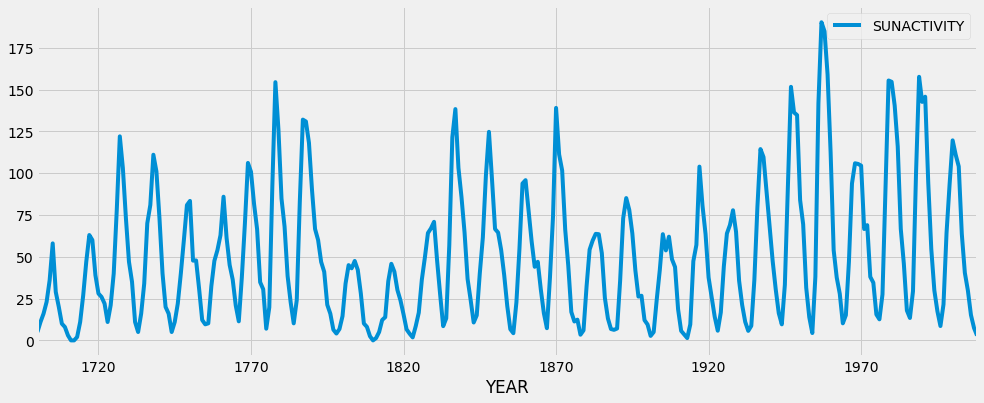

In [369]:
df.plot(figsize=(15, 6))
plt.show()

In [370]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [371]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3439.710598624912
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3155.618267417888
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3049.1506172991085
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2931.5259900073206
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3033.780146812068
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3026.4798616470516
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2942.7951482313892
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2886.6371323059775
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3096.1208215078314
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2861.6446018358524
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2811.132477745641
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2678.63974679911
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2793.0259964972975
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2786.6289655334926
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2713.7993981749396
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2642.560831314979
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2824.8598075257105
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2701.1642233127277

In [461]:
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=(1, 0, 1), 
                                seasonal_order=(1, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False) 
results = mod.fit()


In [462]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7025      0.057     12.281      0.000       0.590       0.815
ma.L1          0.5017      0.057      8.780      0.000       0.390       0.614
ar.S.L12       0.2073      0.072      2.891      0.004       0.067       0.348
ma.S.L12      -1.0000      0.069    -14.510      0.000      -1.135      -0.865
sigma2       361.6977      0.000    1.9e+06      0.000     361.697     361.698


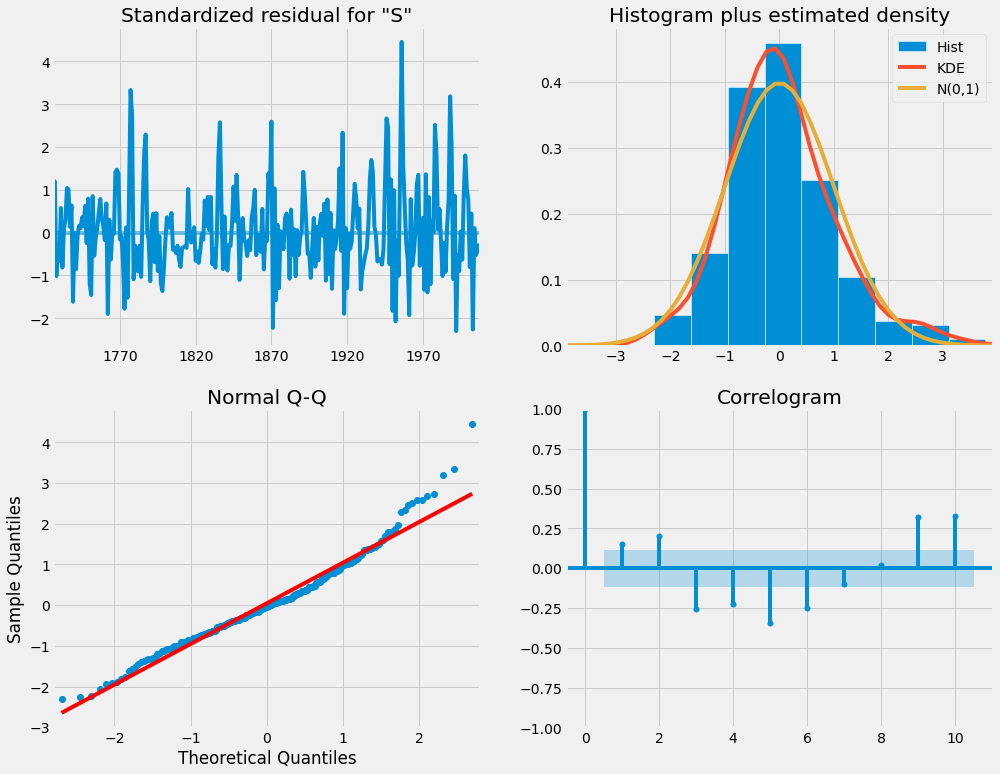

In [463]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [466]:
pred = results.get_prediction(start=pd.to_datetime('1900-01-01'), dynamic=False)
pred_ci = pred.conf_int()

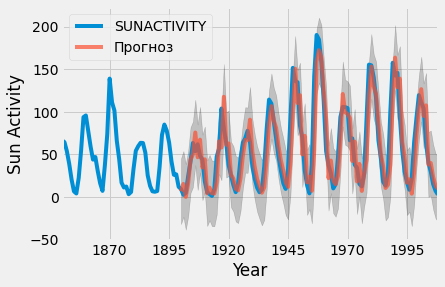

In [467]:
ax = df['1850':].plot(label='Відомі')
pred.predicted_mean.plot(ax=ax, label='Прогноз', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Sun Activity')
plt.legend()
plt.show()

In [468]:
df_forecasted = pred.predicted_mean
df_truth = y['1900-01-01':] 
mse = ((df_forecasted - df_truth) ** 2).mean()
print('Середня квадратна похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратна похибка прогнозів = 523.57


In [469]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1900-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

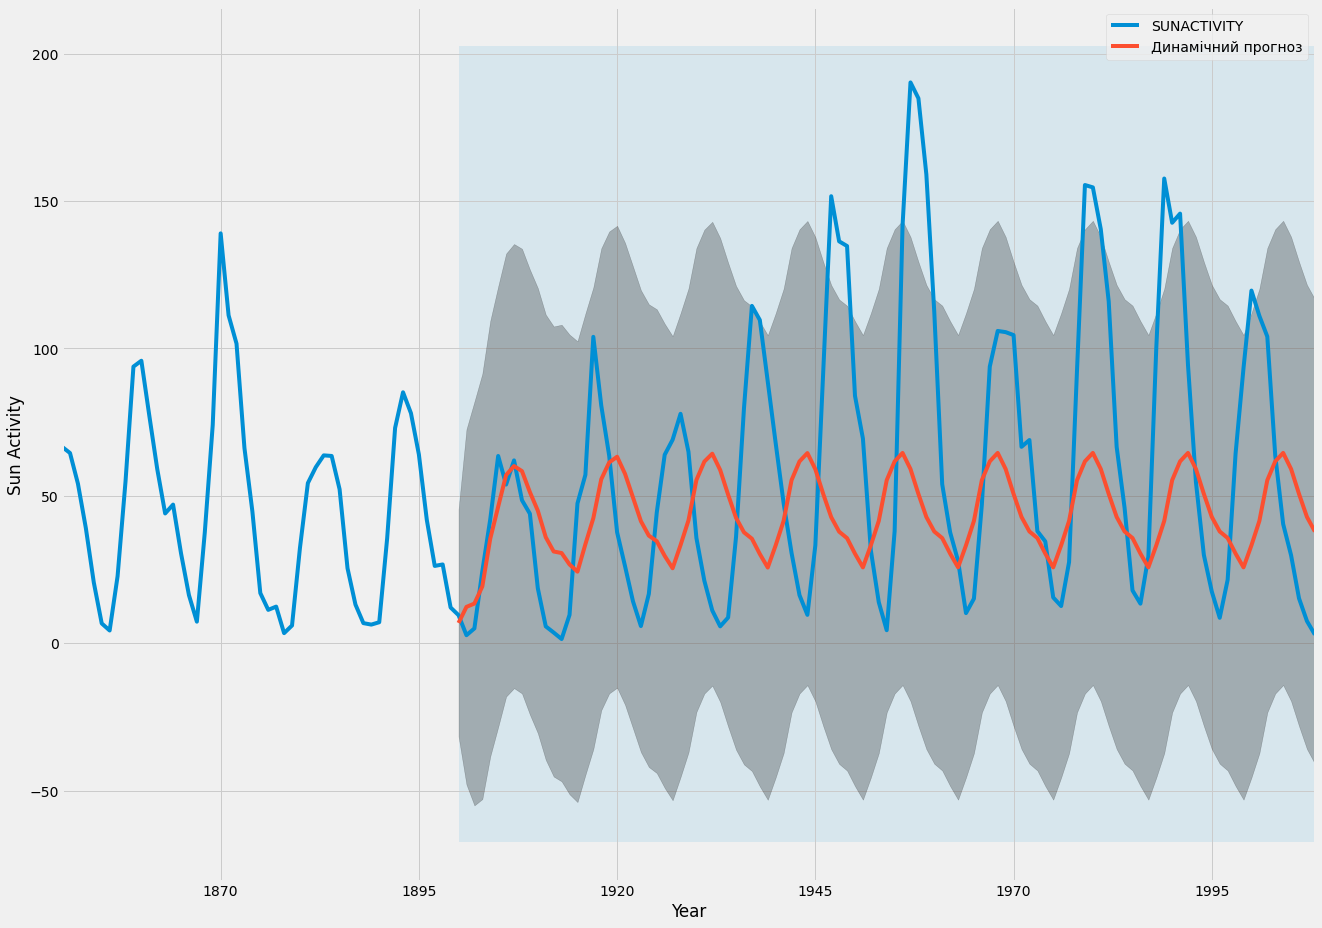

In [470]:
ax = df['1850':].plot(label='Відомі', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Динамічний прогноз', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1900-01-01'), df.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Year')
ax.set_ylabel('Sun Activity')
plt.legend()
plt.show()

In [474]:
df_forecasted = pred_dynamic.predicted_mean
df_truth = y['1900-01-01':]
mse = ((df_forecasted - df_truth) ** 2).mean()
print('Середня квадратна похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратна похибка прогнозів = 2391.74


In [475]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

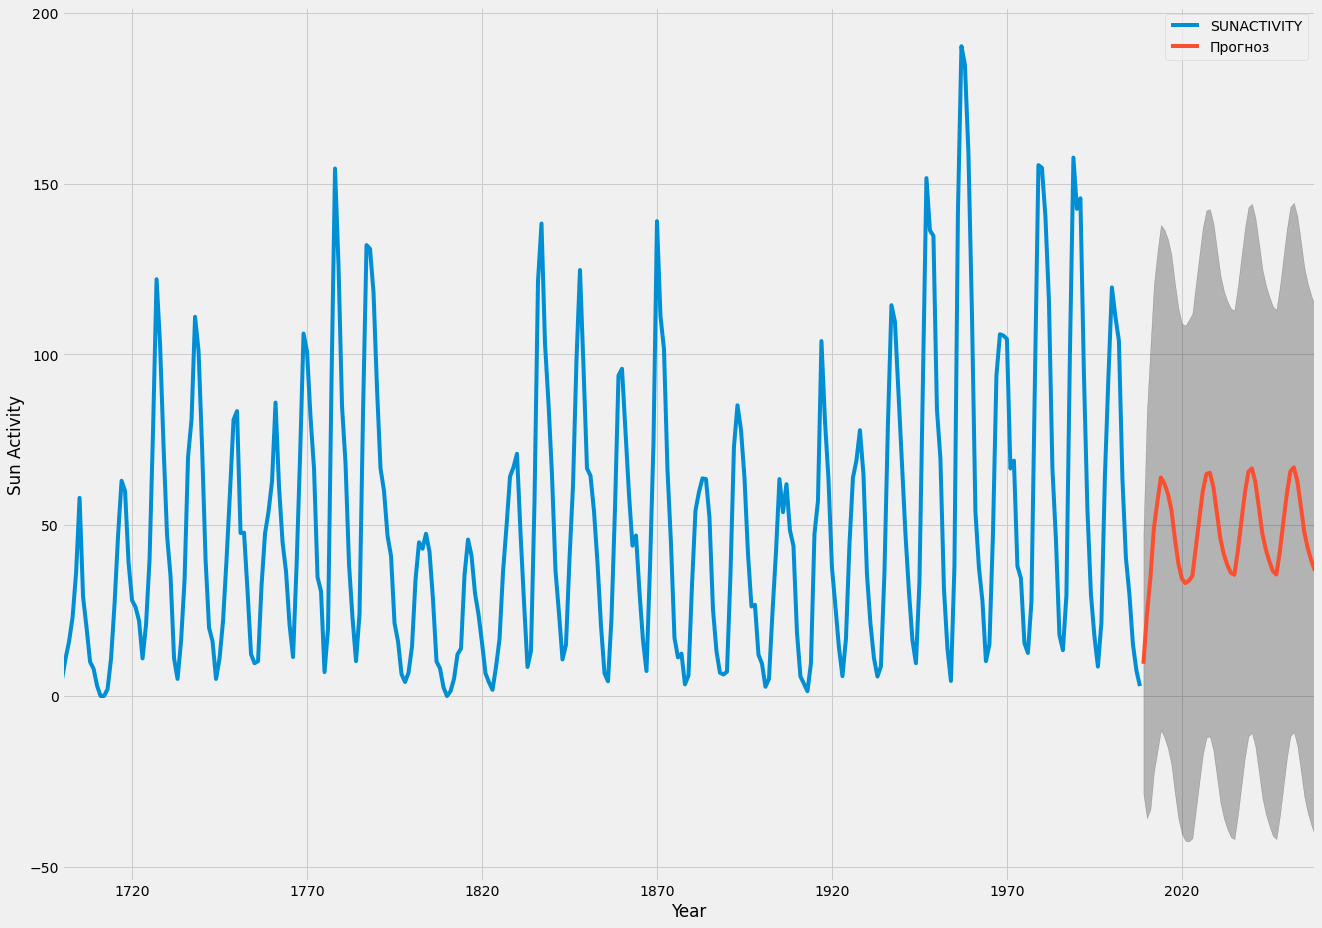

In [476]:
ax = df.plot(label='Відомі', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Sun Activity')
plt.legend()
plt.show()